# BERT Text Classfier

To test the working model running in HuggingFace Spaces Click Here 👉: https://huggingface.co/spaces/abishek-official/Bert_Text_Classification

## Installing Packages and Importing data

In [ ]:
!pip install tensorflow_text
!pip install -U "tensorflow-text==2.15.*"
!pip install -U "tf-models-official==2.15.*"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

Mounting Google drive for Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/dataset.csv")
df.head()

,Message,Category
0,Your a/c XXXXXXXXXX4837 debited for payee SHIV...,banking
1,Rs.50.00 credited to a/c *9385 on 01/07/2024 b...,banking
2,Your a/c no. XXXXXXXXXXXX5632 is credited by I...,banking
3,Dear UPI user A/C X2192 debited by 100.0 on da...,banking
4,ICICI Bank: Rs 100.00 debited from a/c **8211 ...,banking


### Skip the below parts and go to the last of this section to import downsampled dataset if you have Correct amount of data

In [ ]:
#here the nonbanking dataset higher than banking, so we need to downsample the nonbanking class data to get good accuracy
df['Category'].value_counts()

,count
Category,
nonbanking,441
banking,231


In [ ]:
#splitting and storing the data seperate classes
df_banking = df[df['Category']=='banking']
df_non_banking = df[df['Category']=='nonbanking']

In [ ]:
#downsampling the data
df_non_down = df_non_banking.sample(df_banking.shape[0])
df_balanced = pd.concat([df_banking, df_non_down])
df_balanced.head()

,Message,Category
0,Your a/c XXXXXXXXXX4837 debited for payee SHIV...,banking
1,Rs.50.00 credited to a/c *9385 on 01/07/2024 b...,banking
2,Your a/c no. XXXXXXXXXXXX5632 is credited by I...,banking
3,Dear UPI user A/C X2192 debited by 100.0 on da...,banking
4,ICICI Bank: Rs 100.00 debited from a/c **8211 ...,banking


In [ ]:
df_balanced['Category'].value_counts()

,count
Category,
banking,231
nonbanking,231


## Labelling with numerical classes

In [ ]:
df_balanced['banking'] = df_balanced['Category'].apply(lambda x: 1 if x=='banking' else 0)
df_balanced.sample(10)

,Message,Category,banking
236,"Dear Customer, ALERT: You have accessed profil...",nonbanking,0
69,Your a/c no. XXXXXXXX6535 is debited for Rs.80...,banking,1
506,"Dear SBI Customer, your application for a home...",nonbanking,0
89,Your a/c no. XXXXXXXX6535 is debited for Rs.20...,banking,1
76,Your a/c no. XXXXXXXX6535 is debited for Rs.30...,banking,1
7,Rs.35.00 credited to a/c *9486 on 05/07/2024 b...,banking,1
255,"Dear Subscriber, your DTH recharge of Rs. 500....",nonbanking,0
522,"Dear Customer, your PNB account has been flagg...",nonbanking,0
3,Dear UPI user A/C X2192 debited by 100.0 on da...,banking,1
326,"Dear Customer, your Citibank RD maturity amoun...",nonbanking,0


## Splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['banking'], stratify=df_balanced['banking'])

In [ ]:
X_train.head(4)

,Message
455,Thank you for shopping with Flipkart! Your ord...
85,Your a/c no. XXXXXXXX6535 is debited for Rs.40...
668,Uber: Your scheduled ride for tomorrow at 9 AM...
444,Dear UPI user A/C X2092 debited by 45.0 on dat...


## Model Creation

In [ ]:
#We use the BERT model's preprocessor and encoder to create the model and match the labels
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#additionally we add two more layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
11/11 [==============================] - 19s 340ms/step - loss: 0.6851 - accuracy: 0.5809 - precision: 0.5745 - recall: 0.6243
Epoch 2/20
11/11 [==============================] - 4s 319ms/step - loss: 0.6549 - accuracy: 0.6012 - precision: 0.6606 - recall: 0.4162
Epoch 3/20
11/11 [==============================] - 3s 302ms/step - loss: 0.6094 - accuracy: 0.6618 - precision: 0.6129 - recall: 0.8786
Epoch 4/20
11/11 [==============================] - 3s 306ms/step - loss: 0.6036 - accuracy: 0.6792 - precision: 0.8370 - recall: 0.4451
Epoch 5/20
11/11 [==============================] - 4s 354ms/step - loss: 0.5624 - accuracy: 0.7775 - precision: 0.7308 - recall: 0.8786
Epoch 6/20
11/11 [==============================] - 3s 304ms/step - loss: 0.5470 - accuracy: 0.7514 - precision: 0.7919 - recall: 0.6821
Epoch 7/20
11/11 [==============================] - 3s 308ms/step - loss: 0.5264 - accuracy: 0.7890 - precision: 0.8333 - recall: 0.7225
Epoch 8/20
11/11 [======================

## validation

In [ ]:
model.evaluate(X_test, y_test)
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

4/4 [==============================] - 2s 333ms/step


In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[56,  2],
       [ 2, 56]])

Text(50.722222222222214, 0.5, 'Truth')

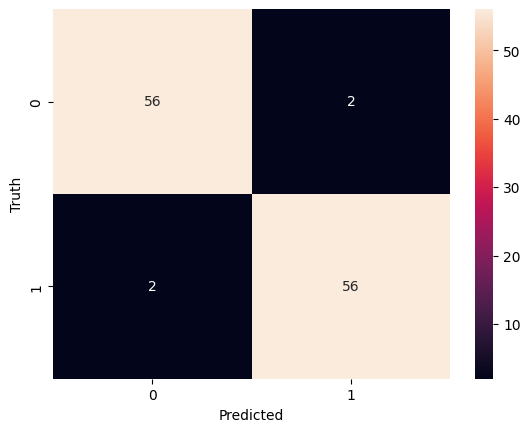

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        58
           1       0.97      0.97      0.97        58

    accuracy                           0.97       116
   macro avg       0.97      0.97      0.97       116
weighted avg       0.97      0.97      0.97       116



## Testing

In [ ]:
def ask(string):
  op = model.predict(string)
  if op[0] > 0.5:
    print("Banking Related")
  else:
    print("Non Banking Related")

In [ ]:
ask(['Dear Customer ,Your SBI Debit Card ending with 8605 has been blocked on 04-Feb-23 at 10:57 Hrs at your request. Never, Never share your PIN / OTP/ CVV with anyone - SBI.'])

1/1 [==============================] - 1s 773ms/step
Non Banking Related


In [ ]:
ask(['Dear Customer, Welcome to State Bank of India. Do not share your Card no/ PIN/ OTP/CVV with anyone. SBI never asks for such details. Do not click on links received from strangers. Please visit the Cyber Security Page under Digital tab of SBI (Bank.sbi) to know more- SBI Infosec Team.'])

1/1 [==============================] - 0s 63ms/step
Non Banking Related


In [ ]:
ask(['Your A/C XXXXXxxxxxx Credited INR 2,400.00 on 08/08/24 -Deposit of Cash at Pandiyan stores CDM. Avl Bal INR 2,465.60-SBI'])

1/1 [==============================] - 0s 45ms/step
Banking Related


In [ ]:
ask(['Your a/c XXXXXXXXXXxxxxx debited for payee JANANI FOOD CORNER for Rs. 60.00 on 2024-07-16, ref 4198097.If not you, report to your bank immediately-IOB.'])

1/1 [==============================] - 0s 41ms/step
Banking Related


## Model saving

**Keras Model**

In [ ]:
model.save('bert_text_classification_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**TensorFlow Model**

In [ ]:
tf.saved_model.save(model, "/content/drive/MyDrive/BERT/saved_model")

### Converting to TFLite

Converting without optimization

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/BERT/saved_model") # path to the SavedModel directory

# Add allow_custom_ops to handle the 'CaseFoldUTF8' operation
converter.experimental_new_converter = True
converter.allow_custom_ops = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

**Converting to TFLite using Optimization techniques**

Refer the below documentation to utilize different Quantization techiniques

https://www.tensorflow.org/lite/performance/post_training_quantization

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/BERT/saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
converter.allow_custom_ops = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_quant_model = converter.convert()

with open('optimized_model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

## To Use the saved tensorflow model

**Load the model**

In [ ]:
# Load the SavedModel
model_path = '/content/drive/MyDrive/BERT/saved_model'
loaded_model = tf.saved_model.load(model_path)

In [ ]:
# Retrieve the inference function (usually 'serving_default')
infer = loaded_model.signatures['serving_default']

**Pre-process the data to feed the model**

The TF Model we built so far accepts only tensor type of data. For that we convert the input string into tensors

In [ ]:
# Prepare your input data, give always as a list of strings
input_data = ['Your input message here']

# Convert the input data to a Tensor
# Ensure that the input tensor matches the expected shape and dtype
input_tensor = tf.constant(input_data, dtype=tf.string)

# Perform inference
# Pass the input tensor to the model, using the correct input name from the signature
predictions = infer(text=input_tensor)

# Extract and print the output
# Ensure you correctly access the output from the dictionary
output_tensor = predictions['output']
print(output_tensor.numpy())